nohup python main_fedavg.py -m wvgg9k4 -d cifar10 -R 4000 -K 5 -M 500 -P 10 --partition exdir --alpha 1 10.0 --optim sgd --lr 0.1 --global-lr 1.0 --batch-size 20 --seed 1234 --clip 10 --eval-num 1000 --device 0 --save-model 0
nohup python main_cwt.py -m wvgg9k4 -d cifar10 -R 4000 -K 5 -M 500 -P 10 --partition exdir --alpha 1 10.0 --optim sgd --lr 0.03 --global-lr 1.0 --batch-size 20 --seed 1234 --clip 50 --eval-num 1000 --device 0 --save-model 0
mean_wvgg9k4_cifar10_exdir1,10.0


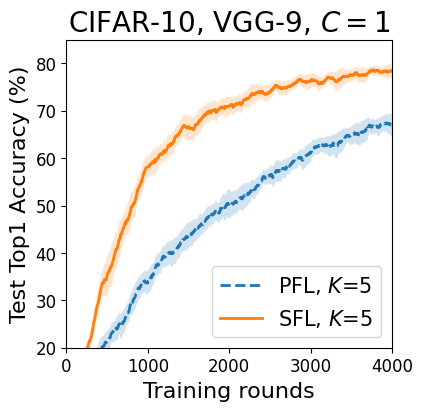

In [3]:
'''
You can 1) perform smoothing on the original standard deviation 
or 2) calculate the standard deviation on the smoothing data.
If using 1), please use the smoothing in preprocess_data, 
If using 2), please use the smoothing in plot_mean;
To the best of our known, both are correct. Here we use the first method.
'''

import sys 
sys.path.append("/media/moon/Data/study/falcon/convergence/")

import os
import re
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from sim.utils.record_utils import read_fromcsv
from plots.plot_utils import moving_average, reassemble_dict2cmd, reassemble_filename2dict

def preprocess_data(patterns, setup):
    seeds = [123, 1234, 12345]
    #seeds = [1234]
    data_patterns = []
    x = None
    y = setup['y']
    legends = []
    # construct data with different seeds
    for i in range(len(patterns)):
        data_per_pattern = [] # with multiple seeds
        data_last_xround_per_pattern = [] # with multiple seeds
        for j in range(len(seeds)):
            tfile = re.sub(r'seed\d+', 'seed{}'.format(seeds[j]), patterns[i])
            tfile = f'{tfile}.csv' if '.csv' not in tfile else tfile
            args = reassemble_filename2dict(tfile)
            if not os.path.exists(os.path.join(path, tfile)):
                if setup['report']:
                    #print('\tNot found {}'.format(tfile))
                    args['alg'] = "{}".format(args['alg'])
                    print(reassemble_dict2cmd(args))
                continue
            df = read_fromcsv(tfile, path)
            if df['round'].values[-1] != setup['end']:
                if setup['report']:
                    #print('\tNot completed {}'.format(tfile))
                    args['alg'] = "{}".format(args['alg'])
                    print(reassemble_dict2cmd(args))
                continue
            # pick the data we want to plot
            step = df['round'].values[1] - df['round'].values[0]
            df = df[df['round'].isin([i for i in range(0, setup['end']+1, step)])]
            # results over last x round 
            out = df.iloc[:, 8].values[-setup['select']:]
            data_last_xround_per_pattern.extend(out.tolist())
            x = df['round'].values
            y_content = df.iloc[:, y].values
            
            # if setup['smooth']:
            #     window_size = int(0.05*setup['end']*0.25) # 0.01*setup['end']*0.25
            #     y_smooth = moving_average(y_content, window_size)
            #     # adjust the length of the smooth data
            #     # discard `len(data)- (len(data)-len(windows)+1)=len(windows)-1` data points
            #     x_smooth = x[len(x)-len(y_smooth):]
            #     # back to the original variable
            #     x, y_content = x_smooth, y_smooth

            # data per seed
            if len(data_per_pattern) == 0:
                data_per_pattern = y_content
            else:
                data_per_pattern =  np.vstack((data_per_pattern, y_content))
        if setup['report']:
            pass
            #print('Avg {}, {:5.2f}\\tiny{{$\\pm${:5<.2f}}}  {}'.format(len(data_last_xround_per_pattern), np.mean(data_last_xround_per_pattern), np.std(data_last_xround_per_pattern), patterns[i]))
            #print('&{:5.2f}\\tiny{{$\\pm${:5<.2f}}}'.format(np.mean(data_last_xround_per_pattern), np.std(data_last_xround_per_pattern)), end=' ')
        data_patterns.append(data_per_pattern)
        legends.append('{}, K={}'.format(args['alg'], args['K']))
    return x, data_patterns, legends


def get_legend(pattern):
    args = reassemble_filename2dict(pattern)
    if args['alg'] == 'FedAvg':
        alg = 'PFL'
    elif args['alg'] == 'CWT':
        alg = 'SFL'
    
    return '{}, $K$={}'.format(alg, args['K'])

# def get_color(filename):
#     if "FedAvg" in filename:
#         return 'C0'
#     elif "SCAFFOLD" in filename:
#         return 'C1'
#     elif "FedAdam" in filename:
#         return 'C2'
#     elif "SSL" in filename:
#         return 'C3'
#     elif "CWT" in filename:
#         return 'C4'
    
def get_color(filename):
    if "K5_" in filename:
        return 'C0'
    elif "K20" in filename:
        return 'C1'
    elif "K50" in filename:
        return 'C2'
    # elif "SSL" in filename:
    #     return 'C3'
    # elif "CWT" in filename:
    #     return 'C4'

def get_color3(filename):
    if "K1_" in filename:
        if 'FedAvg' in filename:
            return [i/255*1.35 for i in (31,119,180)]
        else:
            return [i/255 for i in (31,119,180)]
    if "K5_" in filename:
        if 'FedAvg' in filename:
            return 'orange'
        else:
            return [i/255 for i in (255,127,14)]
    elif "K20" in filename:
        if 'FedAvg' in filename:
            return [i/255*1.25 for i in (44,160,44)]
        else:
            return [i/255 for i in (44,160,44)]
    elif "K50" in filename:
        if 'FedAvg' in filename:
            return 'tomato'
        else:
            return [i/255 for i in (214,39,40)]
    # elif "SSL" in filename:
    #     return 'C3'
    # elif "CWT" in filename:
    #     return 'C4'
    
def get_color2(i):
    a = ['C0', 'C1', 'C2', 'C3', 'C4', 'C7', 'C7', 'C8']
    #return 'C{}'.format(i)
    return a[i]

def get_color4(i):
    a = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8']
    #return 'C{}'.format(i)
    return None
    
def get_title(args):
    model_dict = {
        'logistic':  'Logisitc',
        'mlp': 'MLP',
        'lenet5': 'LeNet-5',
        'cnnmnist': 'CNN',
        'wvgg9k4': 'VGG-9',
        'resnetii18': 'ResNet-18'
        }
    model = model_dict[args[5]]
    dataset_dict = {
        'mnist': 'MNIST', 
        'fashionmnist': 'FMNIST',
        'cifar10': 'CIFAR-10',
        'cifar100': 'CIFAR-100',
        'cinic10': 'CINIC-10'
    }
    dataset = dataset_dict[args[6]]
    if args[3] == 'K5':
        K = '$K=5$'
    elif args[3] == 'K20':
        K = '$K=20$'
    elif args[3] == 'K50':
        K = '$K=50$'
    if 'exdir' in args[7]:
        t = re.sub(r'exdir', '', args[7])
        t = t.split(',')[0]
        #partition = 'ExDir({}, 10.0)'.format(t)
        partition = '$C={}$'.format(t)
    else:
        partition = 'IID'
    #return '{}, {}, {}'.format(dataset, partition, K)
    return '{}, {}, {}'.format(dataset, model, partition)

def format_y_ticks1(y, pos):
    return f'{y:.2f}'

def format_y_ticks2(y, pos):
    return f'{y:.0f}'

def plot_mean_one(patterns, setup):
    global path
    
    args = patterns[0].split('_')
    ylabels = ['Round', 'Training Loss', 'Training Top1 Accuracy (%)', 'Training Top5 Accuracy (%)',  'Training-R Loss', 'Training-R Top1 Accuracy (%)', 'Training-R Top5 Accuracy (%)', 'Test Loss', 'Test Top1 Accuracy (%)', 'Test Top5 Accuracy (%)']
    #ylabels = ['Test Top1 Accuracy (%)']
    xlabel = 'Training rounds' 

    x1, data1_patterns, legends1 = preprocess_data(patterns, setup=setup)
    
    fig, axs = plt.subplots(1, 1, figsize=(4.2, 4)) # 3, 5.4, 3.6
    for i in range(len(patterns)):
        if len(data1_patterns[i]) > 3:
            mean1 = data1_patterns[i]
            std1 = np.zeros_like(mean1)
        else:
            mean1 = data1_patterns[i].mean(axis=0)
            std1 = data1_patterns[i].std(axis=0)
        # smooth
        if setup['smooth']:
            window_size = int(0.03*setup['end']*0.25) # 0.01*setup['end']*0.25
            mean_smooth = moving_average(mean1, window_size)
            std_smooth = moving_average(std1, window_size)
            x_smooth = x1[len(x1)-len(mean_smooth):]
            # back to the original variable
            x1, mean1, std1 = x_smooth, mean_smooth, std_smooth

        if 'FedAvg' in patterns[i]:
            linestyle = '--'
        else:
            linestyle = '-'
        axs.plot(x1, mean1, linestyle=linestyle, color=get_color2(i), lw=2, label=get_legend(patterns[i]))
        axs.fill_between(x1, mean1-std1, mean1+std1, facecolor=get_color2(i), alpha=0.2)
        # plt.fill_between(x_axis, FedAvgdata[i].min(axis=0), FedAvgdata[i].max(axis=0), facecolor=colors[i], alpha=0.25) 
         
    axs.set_title(get_title(args), fontsize=20)
    axs.set_ylabel(ylabels[setup['y']], fontsize=16)
    axs.set_xlabel(xlabel, fontsize=16)
    axs.tick_params(labelsize=12)
    axs.set_xlim(xmin=0, xmax=setup['point'])
    axs.set_ylim(ymin=20, ymax=85)
    formatter = ticker.FuncFormatter(format_y_ticks2)
    axs.yaxis.set_major_formatter(formatter)
    #axs.grid()
    #if 'exdir1' in patterns[0] and 'cifar10' in patterns[0] and 'wvgg9k4' in patterns[0]:
    axs.legend(loc=4, ncol=1, prop={'size': 15}) # loc = 1 or 4
    filename = 'mean_{}_{}_{}'.format(args[5], args[6], args[7])
    print(filename)
    #plt.savefig('../figs/{}.png'.format(filename), bbox_inches='tight', dpi=300)

def plot_mean(patterns, setup):
    global path
    
    args = patterns[0].split('_')
    ylabels = ['Round', 'Training Loss', 'Training Top1 Accuracy (%)', 'Training Top5 Accuracy (%)',  'Training-R Loss', 'Training-R Top1 Accuracy (%)', 'Training-R Top5 Accuracy (%)', 'Test Loss', 'Test Top1 Accuracy (%)', 'Test Top5 Accuracy (%)']
    #ylabels = ['Test Top1 Accuracy (%)']
    xlabel = 'Training rounds' 

    xs, datas_patterns = [], []
    for c in setup['y']:
        xsetup = setup.copy()
        xsetup['y'] = c

        x, data_patterns, _ = preprocess_data(patterns, setup=xsetup)
        xs.append(x)
        datas_patterns.append(data_patterns)
    
    fig, axs = plt.subplots(1, len(setup['y']), figsize=(24, 4))
    for c in range(len(setup['y'])):
        for i in range(len(patterns)):
            if len(datas_patterns[c][i]) > 3:
                mean = datas_patterns[c][i]
                std = np.zeros_like(mean)
            else:
                mean = datas_patterns[c][i].mean(axis=0)
                std = datas_patterns[c][i].std(axis=0)
            x = xs[c]
            # smooth
            if setup['smooth']:
                if setup['end'] == 1000:
                    window_size = int(0.08*setup['end']*0.25)
                else:
                    window_size = int(0.04*setup['end']*0.25)
                #window_size = 30
                mean_smooth = moving_average(mean, window_size)
                std_smooth = moving_average(std, window_size)
                x_smooth = x[len(x)-len(mean_smooth):]
                # back to the original variable
                x, mean, std = x_smooth, mean_smooth, std_smooth
            if 'FedAvg' in patterns[i]:
                linestyle = '--'
            else:
                linestyle = '-'
            axs[c].plot(x, mean, linestyle=linestyle, color=get_color2(i), lw=1.5, label=get_legend(patterns[i]))
            axs[c].fill_between(x, mean-std, mean+std, facecolor=get_color2(i), alpha=0.1) # 0.2
            # plt.fill_between(x_axis, FedAvgdata[i].min(axis=0), FedAvgdata[i].max(axis=0), facecolor=colors[i], alpha=0.25)

            axs[c].set_title(get_title(args), fontsize=16)
            axs[c].set_ylabel(ylabels[setup['y'][c]], fontsize=16)
            axs[c].set_xlabel(xlabel, fontsize=16)
            axs[c].tick_params(labelsize=12)
            axs[c].set_xlim(xmin=0, xmax=setup['point'])
            axs[c].grid(True)
            if c == 0:
                a = axs[c].legend(loc=1, ncol=1, prop={'size': 15}) # loc = 1 or 4
                #a.set_alpha(0.1)
            if setup['y'][c] in [1, 4, 7]:
                #axs[c].set_ylim(ymax = datas_patterns[1][0].mean(axis=0)[6], ymin=datas_patterns[0][3].mean(axis=0)[-1]-0.03)
                axs[c].set_ylim(ymin=0.2, ymax=3)
                formatter = ticker.FuncFormatter(format_y_ticks1)
                axs[c].yaxis.set_major_formatter(formatter)
            if setup['y'][c] in [2, 5, 8]:
                #axs[c].set_ylim(ymin = datas_patterns[4][0].mean(axis=0)[6]-0.5, ymax=datas_patterns[2][3].mean(axis=0)[-1]+0.5)
                axs[c].set_ylim(ymin=20, ymax=92)
                formatter = ticker.FuncFormatter(format_y_ticks2)
                axs[c].yaxis.set_major_formatter(formatter)
            

    plt.subplots_adjust(wspace=0.3)
    filename = 'mean2_{}_{}_{}'.format(args[5], args[6], args[7])
    print(filename)
    plt.savefig('../figs/{}.pdf'.format(filename), bbox_inches='tight', dpi=300)

path = f"/media/moon/Data/study/falcon/convergence/save/formal/"

def main():
    patterns = [

'FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
#'FedAvg_M500_P10_K20_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
#'FedAvg_M500_P10_K50_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
'CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
#'CWT_M500_P10_K20_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.003,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
#'CWT_M500_P10_K50_R4000_wvgg9k4_cifar10_exdir1,10.0_sgd0.003,1.0,0.0,0.0001_b20_seed1234_clip50.csv',

# #'FedAvg_M500_P10_K1_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
# 'FedAvg_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
# 'FedAvg_M500_P10_K20_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
# 'FedAvg_M500_P10_K50_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.1,1.0,0.0,0.0001_b20_seed1234_clip10.csv',
# #'CWT_M500_P10_K1_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
# 'CWT_M500_P10_K5_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.03,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
# 'CWT_M500_P10_K20_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.01,1.0,0.0,0.0001_b20_seed1234_clip50.csv',
# 'CWT_M500_P10_K50_R4000_wvgg9k4_cifar10_exdir2,10.0_sgd0.01,1.0,0.0,0.0001_b20_seed1234_clip50.csv',


    ]
    # end=1000, select=10, end=4000, select=25
    plot_mean_one(patterns=patterns, setup={'start': 1, 'point': 4000, 'end': 4000, 'y': 8, 'select': 10, 'report': 1, 'smooth': 1})
    #plot_mean(patterns=patterns, setup={'start': 1, 'point': 4000, 'end': 4000, 'y': [1, 4, 2, 5, 8], 'select': 10, 'report': 1, 'smooth': 1})

if __name__ == '__main__':
    main()